# Assignment 3.1

Firstly, we load numerical and plotting libraries:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## The Euler-Cromer method for central forces

We consider motion of a particle with reduced mass $\mu$ under a central force
$$
\mathbf{F}(\mathbf{r}) \;=\; -\,F(r)\,\frac{\mathbf{r}}{r}, \qquad r = \|\mathbf{r}\|,\; F(r) > 0,
$$
so that the equation of motion reads
$$
\ddot{\mathbf{r}} \;=\; \frac{1}{\mu}\,\mathbf{F}(\mathbf{r}).
$$

We wish to solve this numerically, employing the **Euler–Cromer** method.
To this end, at each time step we update the velocity and the radial coordinate as follows:
$$
\mathbf{v}_{n+1} = \mathbf{v}_n + \Delta t \, \mathbf{a}(\mathbf{r}_n),\\\\
\mathbf{r}_{n+1} = \mathbf{r}_n + \Delta t \, \mathbf{v}_{n+1},
$$
with $\mathbf{a}(\mathbf{r}) = \mathbf{F}(\mathbf{r})/\mu$. 
A simple code achieving this - similar to the one in Assignment 2 - is the following:

In [ ]:
def euler_cromer_2d(accel_fn, r0, v0, dt, tmax, mu=1.0):
    """
    Integrate r'' = a(r) with Euler–Cromer in 2D.

    -------

    Parameters:
    accel_fn : acceleration at position r (2-vector):
        a(r) -> (ax, ay); 
    r0 : array-like
        Initial position (x0, y0);
    v0 : array-like
        Initial velocity (vx0, vy0);
    dt : float
        Time step;
    tmax : float
        Final time (inclusive);
    mu : float, optional
        Reduced mass (though not strictly needed here).

    -------

    Returns
    
    dict of arrays: keys 't','r','v'

    """

    # Parameters and initial conditions

    r0 = np.asarray(r0, dtype=float)
    v0 = np.asarray(v0, dtype=float)
    N = int(np.ceil(tmax/dt)) + 1
    t = np.linspace(0.0, dt*(N-1), N)
    r = np.empty((N,2), dtype=float)
    v = np.empty((N,2), dtype=float)
    r[0] = r0
    v[0] = v0

    # Here is the Euler-Cromer update:
    for n in range(N-1):
        a = np.asarray(accel_fn(r[n]), dtype=float)
        v[n+1] = v[n] + dt * a
        r[n+1] = r[n] + dt * v[n+1]

    return { "t": t, "r": r, "v": v, "mu": mu }


## Mercury orbits under Newtonian gravity

We work with astronomical units (**AU**) for distance and **years** (**yr**) for time. With this choice, for instance, Earth is at $r=1\, \mathrm{AU}$ and has a period of $1\, \mathrm{yr}$. 

For the Sun, we have
$$
GM = 4\pi^2\,.
$$

We also use the initial conditions:
$$
x(0)=0.47 \, \mathrm{AU},\quad y(0)=0 \, \mathrm{AU},\quad v_x(0)=0 \, \mathrm{AU/yr},\quad v_y(0)=8.2 \, \mathrm{AU/yr}.
$$

> Recall that we have to choose the timestep $\Delta t$ sufficiently small so that the trajectory is a clean ellipse

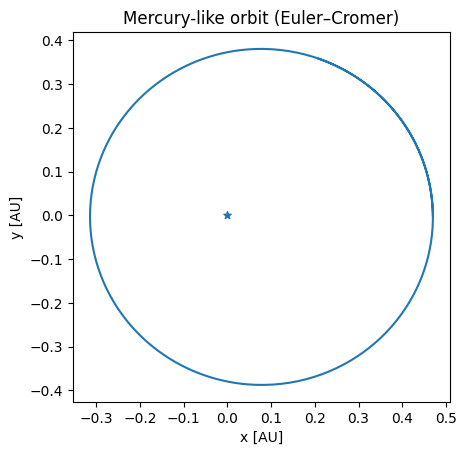

In [ ]:
# Set up GM for the Sun
GM = 4*math.pi**2  # AU^3 / yr^2

# We define the acceleration for Netonian gravity
def accel_newtonian(r, GM=GM, mu=1.0, m=1.0):
    x, y = r
    rr = math.hypot(x, y)
    ax = -GM * x / rr**3
    ay = -GM * y / rr**3
    return np.array([ax, ay])

# Initial conditions (AU, AU/yr)
r0 = np.array([0.47, 0.0]) # 0.47 is the aphelion
v0 = np.array([0.0, 8.2])

# Integrate for several revolutions
dt   = 1e-3     # years - This has to be small enough to have clean orbits!
tmax = 10    # years, adjust as desired - Notice that Mercury has a revolution of just 88 days!

# We take the trajectory from the euler_cromer_2d function defined above
traj = euler_cromer_2d(lambda r: accel_newtonian(r, GM=GM), r0, v0, dt, tmax)

# Plot orbit

r = traj['r']

plt.figure()
plt.plot(r[:,0], r[:,1], lw=1.5)
plt.scatter([0.0],[0.0], s=30, marker='*')  # Sun at origin

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Mercury-like orbit (Euler–Cromer)')

plt.show()


## Deviations from the $1/r^2$-law and perihelion precession

We now consider the modified force
$$
\mathbf{F}(\mathbf{r}) = -\,\frac{GM m}{r^2} \left(1 + \frac{\alpha}{r^2}\right) \hat{\mathbf{r}}.
$$

Below, we will choose $\alpha \in\{0.001,\,0.005,\,0.01\}\,\mathrm{AU}^2$.

With respect to the Newtonian case above, we only have to modify the acceleration:

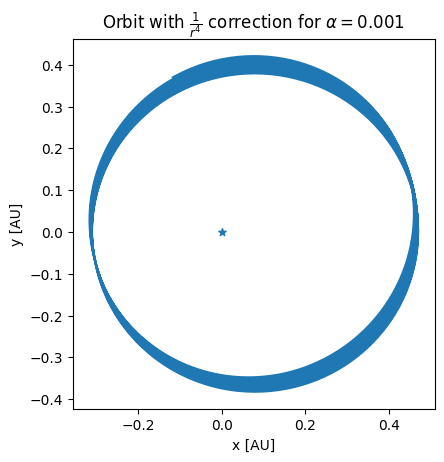

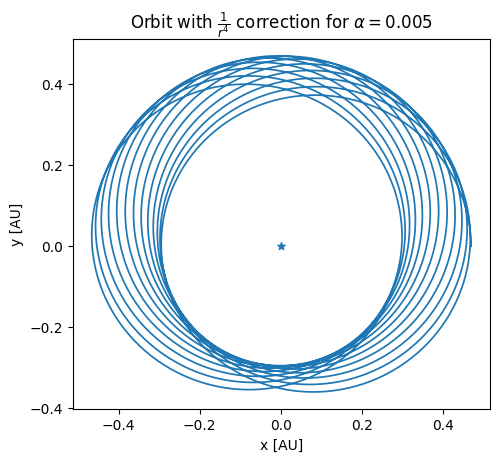

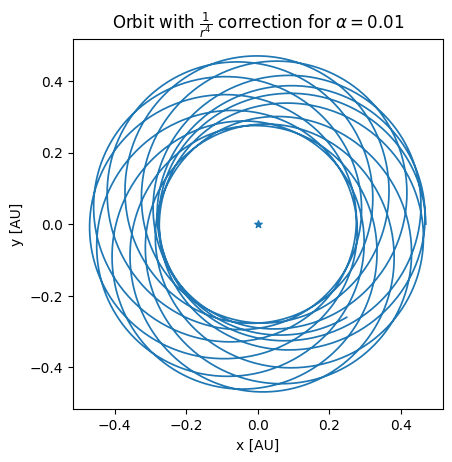

In [26]:
def accel_modified(r, GM=GM, alpha=0.0):
    x, y = r
    rr = math.hypot(x, y)
    fac = - GM * (1.0 + alpha/rr**2) / rr**3

    return np.array([fac * x, fac * y])


# Integrate for several revolutions
dt   = 1e-3     # years - This has to be small enough to have clean orbits!
tmax = 3    # years, adjust as desired - Notice that Mercury has a revolution of just 88 days!


# Here we obtain the trajectories for the various alphas
alphas = [0.001, 0.005, 0.01]  # AU^2
results = {}
for a in alphas:
    traj_a = euler_cromer_2d(lambda r: accel_modified(r, GM=GM, alpha=a), r0, v0, dt, tmax)
    results[a] = {"traj": traj_a}


# ...and we visualise orbits for each alpha
for a, pack in results.items():
    r = pack['traj']['r']
    plt.figure()
    plt.plot(r[:,0], r[:,1], lw=1.25, label=f'alpha={a:.3f} AU^2')
    plt.scatter([0.0],[0.0], s=30, marker='*')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('x [AU]'); plt.ylabel('y [AU]')
    plt.title(r"Orbit with $\frac{1}{r^4}$ correction for $\alpha = %.3g$" % a)
    # plt.legend()
    plt.show()


Although not strictly needed, we here compute the average precession of the perihelion:

In [ ]:
def perihelia_angles(t, r):
    rr = np.hypot(r[:,0], r[:,1])
    # detect local minima (necessary for obtaining the perihelia)
    mid = rr[1:-1]
    idx = np.where((mid < rr[:-2]) & (mid < rr[2:]))[0] + 1

    # unwrap the full azimuth time series, THEN sample at perihelia
    theta_full = np.unwrap(np.arctan2(r[:,1], r[:,0]))
    return t[idx], theta_full[idx]

def precession_stats(t, r):
    tp, th = perihelia_angles(t, r)
    if len(th) < 2:
        return {"peri_times": tp, "peri_angles": th,
                "per_orbit_precession_rad": np.array([]),
                "deg_per_year_series": np.array([]),
                "avg_deg_per_year": np.nan}

    dth = np.diff(th)              # this is ~ 2π + δ
    # Filter obvious mis-detections (half-turns, etc.)
    ok = (dth > np.pi) & (dth < 3*np.pi)
    dth = dth[ok]
    dT  = np.diff(tp)[ok]

    dvarpi = dth - 2*np.pi         # small number in radians
    deg_per_year = np.degrees(dvarpi) / dT
    return {"peri_times": tp, "peri_angles": th,
            "per_orbit_precession_rad": dvarpi,
            "deg_per_year_series": deg_per_year,
            "avg_deg_per_year": np.nanmean(deg_per_year) if deg_per_year.size else np.nan}


# We compute the average precession for them (Notice that we need several orbits to find it!)
for a, pack in results.items():
    traj = pack["traj"]
    pack["stats"] = precession_stats(traj["t"], traj["r"])

# We print out the results
for a, pack in results.items():
    avg = pack['stats']['avg_deg_per_year']
    print(f"alpha={a:.3f} AU^2 -> average precession ≈ {avg:.6f} °/yr")

alpha=0.001 AU^2 -> average precession ≈ 10.136862 °/yr
alpha=0.005 AU^2 -> average precession ≈ 57.892881 °/yr
alpha=0.010 AU^2 -> average precession ≈ 131.493275 °/yr
